In [2]:
import pandas as pd
import numpy as np 
import torch 
import torchvision
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

### Load the Dataset

In [3]:
# input data 
data_path = "/kaggle/input/hypertension-risk-prediction-dataset/hypertension_dataset.csv"
df = pd.read_csv(data_path)

In [4]:
#datset overview 
print(df.shape)
print(df.head())
df.info()
df.describe()

(1985, 11)
   Age  Salt_Intake  Stress_Score       BP_History  Sleep_Duration   BMI  \
0   69          8.0             9           Normal             6.4  25.8   
1   32         11.7            10           Normal             5.4  23.4   
2   78          9.5             3           Normal             7.1  18.7   
3   38         10.0            10     Hypertension             4.2  22.1   
4   41          9.8             1  Prehypertension             5.8  16.2   

      Medication Family_History Exercise_Level Smoking_Status Has_Hypertension  
0            NaN            Yes            Low     Non-Smoker              Yes  
1            NaN             No            Low     Non-Smoker               No  
2            NaN             No       Moderate     Non-Smoker               No  
3  ACE Inhibitor             No            Low     Non-Smoker              Yes  
4          Other             No       Moderate     Non-Smoker               No  
<class 'pandas.core.frame.DataFrame'>
RangeInd

,Age,Salt_Intake,Stress_Score,Sleep_Duration,BMI
count,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000
mean,50.341058,8.531688,4.979345,6.452242,26.015315
std,19.442042,1.994907,3.142303,1.542207,4.512857
min,18.000000,2.500000,0.000000,1.500000,11.900000
25%,34.000000,7.200000,2.000000,5.400000,23.000000
50%,50.000000,8.500000,5.000000,6.500000,25.900000
75%,67.000000,9.900000,8.000000,7.500000,29.100000
max,84.000000,16.400000,10.000000,11.400000,41.900000


In [5]:
# check unique- values in medication column
df['Medication']= df['Medication'].fillna('None')
df['Medication'].isnull().sum()
df['Medication'].value_counts()

Medication
None             799
Beta Blocker     412
ACE Inhibitor    323
Diuretic         245
Other            206
Name: count, dtype: int64

### Pre-processing steps

##### Encoding Binary and Multi-class Categorical Variables

In [6]:
# list of binary columns
binary_cols = ['Family_History', 'Smoking_Status', 'Has_Hypertension']
label_encoder = LabelEncoder()
for col in binary_cols:
    df[col] = label_encoder.fit_transform(df[col])
df[binary_cols].head()

,Family_History,Smoking_Status,Has_Hypertension
0,1,0,1
1,0,0,0
2,0,0,0
3,0,0,1
4,0,0,0


In [7]:
# list of multi-class categorical variables
multi_class_cols = ['BP_History', 'Medication','Exercise_Level']
df = pd.get_dummies(df,columns=multi_class_cols,drop_first=True)
df = df.astype(int)
df.head()


,Age,Salt_Intake,Stress_Score,Sleep_Duration,BMI,Family_History,Smoking_Status,Has_Hypertension,BP_History_Normal,BP_History_Prehypertension,Medication_Beta Blocker,Medication_Diuretic,Medication_None,Medication_Other,Exercise_Level_Low,Exercise_Level_Moderate
0,69,8,9,6,25,1,0,1,1,0,0,0,1,0,1,0
1,32,11,10,5,23,0,0,0,1,0,0,0,1,0,1,0
2,78,9,3,7,18,0,0,0,1,0,0,0,1,0,0,1
3,38,10,10,4,22,0,0,1,0,0,0,0,0,0,1,0
4,41,9,1,5,16,0,0,0,0,1,0,0,0,1,0,1


##### Standardize the numerical features

In [8]:
num_cols = ['Age','Salt_Intake', 'Stress_Score', 'Sleep_Duration', 'BMI']
scaler = StandardScaler()
df[num_cols]=scaler.fit_transform(df[num_cols])

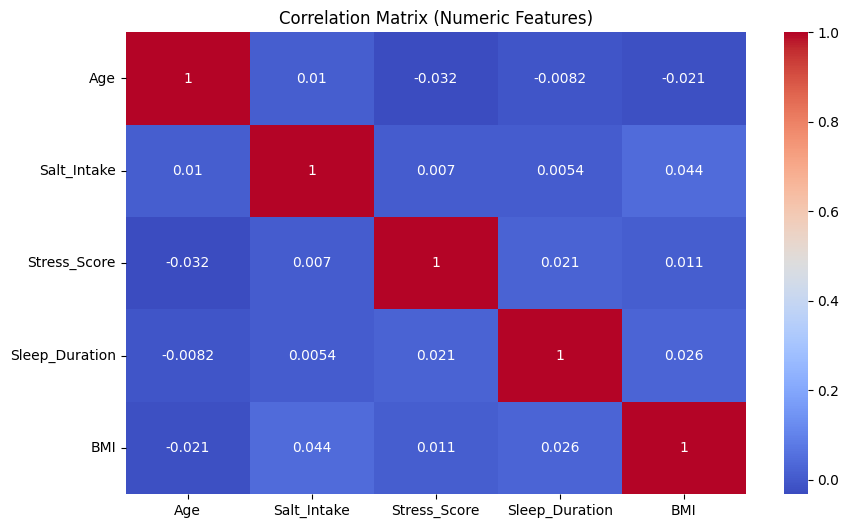

In [9]:
#heatmap to check correlation
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

##### Split dataset into features and target

In [10]:
X = df.drop('Has_Hypertension', axis=1)
y = df['Has_Hypertension']

##### Train-test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state =42
)

### Logistic Regression

In [12]:
# train the model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [13]:
# make predictions
y_pred = model.predict(X_test)

In [14]:
# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
# this means that 171 is correctly predixcted
# 21 is predicted yes but actually no
# 27 is predicted no but actually yes
# 178 is correctly predicted
# overall model is pretty accurate and correctly identified most people at risk
# the main concern is the 27 people who are at risk but were missed
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8790931989924433
Confusion Matrix:
 [[171  21]
 [ 27 178]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88       192
           1       0.89      0.87      0.88       205

    accuracy                           0.88       397
   macro avg       0.88      0.88      0.88       397
weighted avg       0.88      0.88      0.88       397



### Random Forest

In [15]:
#initialize the model
rf_model = RandomForestClassifier(n_estimators =100, max_depth = 5, random_state=42)


In [16]:
#train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [17]:
# make predictions
y_pred = rf_model.predict(X_test)

In [18]:
# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9596977329974811
Confusion Matrix:
 [[185   7]
 [  9 196]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       192
           1       0.97      0.96      0.96       205

    accuracy                           0.96       397
   macro avg       0.96      0.96      0.96       397
weighted avg       0.96      0.96      0.96       397



### Plot

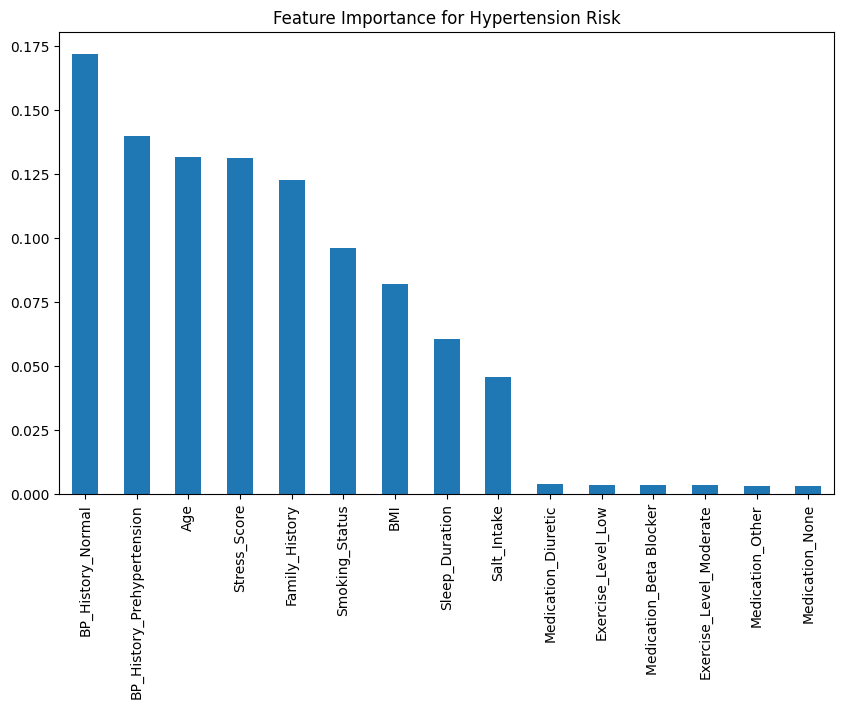

In [19]:
feat_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importance = feat_importance.sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importance.plot(kind="bar")
plt.title("Feature Importance for Hypertension Risk")
plt.show()

In [24]:
import pickle

with open('/kaggle/working/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)